In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from sklearn.model_selection import train_test_split
import keras

from wavhandler import *
from utils import *

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)
import seaborn as sns
sns.set()

import librosa
from scipy import signal
import math
seed = 2018
np.random.seed(seed)
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras import layers

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger

from keras import Model
from keras import backend as K

from keras.utils import np_utils
from keras.preprocessing import image

from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception

Using TensorFlow backend.


In [2]:
target_names = all_6
current_model = DenseNet121
model_name = './data/wingbeats_' + current_model.__name__

best_weights_path = model_name + '.h5'
log_path = model_name + '.log'
monitor = 'val_acc'
batch_size = 32
epochs = 100
es_patience = 7
rlr_patience = 3

SR = 8000
N_FFT = 256
HOP_LEN = int(N_FFT / 6)
input_shape = (129, 120, 1)

img_input = Input(shape = input_shape)
pretrained = current_model(input_tensor = img_input, 
                           classes = len(target_names), 
                           weights = best_weights_path)

In [3]:
bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
target_names = bi_classes
X_names,y = get_data(target_names=bi_classes, nr_signals=999999, only_names=True)

X_names, y = shuffle(X_names, y, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_names, y, stratify = y, test_size = 0.20, random_state = seed)
# y_train = keras.utils.to_categorical(y_train, num_classes=2)
# y_test = keras.utils.to_categorical(y_test, num_classes=2)

100%|██████████| 2/2 [00:00<00:00, 27.57it/s]


In [4]:
out = pretrained.get_layer(pretrained.layers[-2].name).output
out = layers.Dense(16, activation='relu')(out)
out = layers.Dense(1, activation='sigmoid')(out)
new_model = Model(inputs=img_input, outputs=out)

for layer in new_model.layers[:-2]:
    layer.trainable = False
for layer in new_model.layers[-10:]:
    print(layer, layer.trainable)

adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

new_model.compile(optimizer = adm, loss = 'binary_crossentropy', metrics = ['accuracy'])

<keras.layers.core.Activation object at 0x7fe482291ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fe48227b160> False
<keras.layers.normalization.BatchNormalization object at 0x7fe48225cb38> False
<keras.layers.core.Activation object at 0x7fe482161128> False
<keras.layers.convolutional.Conv2D object at 0x7fe482178f28> False
<keras.layers.merge.Concatenate object at 0x7fe48207f080> False
<keras.layers.normalization.BatchNormalization object at 0x7fe4820c7828> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe48205a898> False
<keras.layers.core.Dense object at 0x7fe452ee96a0> True
<keras.layers.core.Dense object at 0x7fe48003ddd8> True


In [5]:
def shift(x, wshift, hshift, row_axis = 0, col_axis = 1, channel_axis = 2, fill_mode = 'constant', cval = 0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_data_shift(data, w_limit = (-0.25, 0.25), h_limit = (-0.0, 0.0), cval = 0., u = 0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        data = shift(data, wshift, hshift, cval = cval)
    return data

def train_generator():
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]

            for i in range(len(train_batch)):
                data, rate = librosa.load(train_batch[i], sr = SR)

                #data = random_data_shift(data, u = 1.0)

                data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
#                 data = librosa.amplitude_to_db(data)
                data = np.abs(data)
                data = np.flipud(data)

                data = np.expand_dims(data, axis = -1)
                data = random_data_shift(data, w_limit = (-0.25, 0.25), h_limit = (-0.0, 0.0), cval = np.min(data), u = 1.0)

                # data = np.squeeze(data, axis = -1)
                # plt.imshow(data, cmap = 'gray')
                # plt.show()
                # data = np.expand_dims(data, axis = -1)

                x_batch.append(data)
                y_batch.append(labels_batch[i])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)

            #y_batch = np_utils.to_categorical(y_batch, len(target_names))

            yield x_batch, y_batch

def valid_generator():
    while True:
        for start in range(0, len(X_test), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(X_test))
            test_batch = X_test[start:end]
            labels_batch = y_test[start:end]

            for i in range(len(test_batch)):
                data, rate = librosa.load(test_batch[i], sr = SR)

                data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
#                 data = librosa.amplitude_to_db(data)
                data = np.abs(data)
                data = np.flipud(data)

                data = np.expand_dims(data, axis = -1)

                x_batch.append(data)
                y_batch.append(labels_batch[i])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)

            #y_batch = np_utils.to_categorical(y_batch, len(target_names))

            yield x_batch, y_batch

callbacks_list = [ModelCheckpoint(monitor = monitor,
                                filepath = best_weights_path[:-3]+'_binary.h5',
                                save_best_only = True,
                                save_weights_only = True,
                                verbose = 1),
                    EarlyStopping(monitor = monitor,
                                patience = es_patience,
                                verbose = 1),
                    ReduceLROnPlateau(monitor = monitor,
                                factor = 0.1,
                                patience = rlr_patience,
                                verbose = 1),
                    CSVLogger(filename = log_path)]


In [6]:
for start in range(0, len(X_test), batch_size):
    x_batch = []
    y_batch = []

    end = min(start + batch_size, len(X_test))
    test_batch = X_test[start:end]
    labels_batch = y_test[start:end]

    for i in range(len(test_batch)):
        data, rate = librosa.load(test_batch[i], sr = SR)

        data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
#                 data = librosa.amplitude_to_db(data)
        data = np.abs(data)
        data = np.flipud(data)

        data = np.expand_dims(data, axis = -1)

        x_batch.append(data)
        y_batch.append(labels_batch[i])
    break

Text(0.5, 1.0, '(129, 120, 1)')

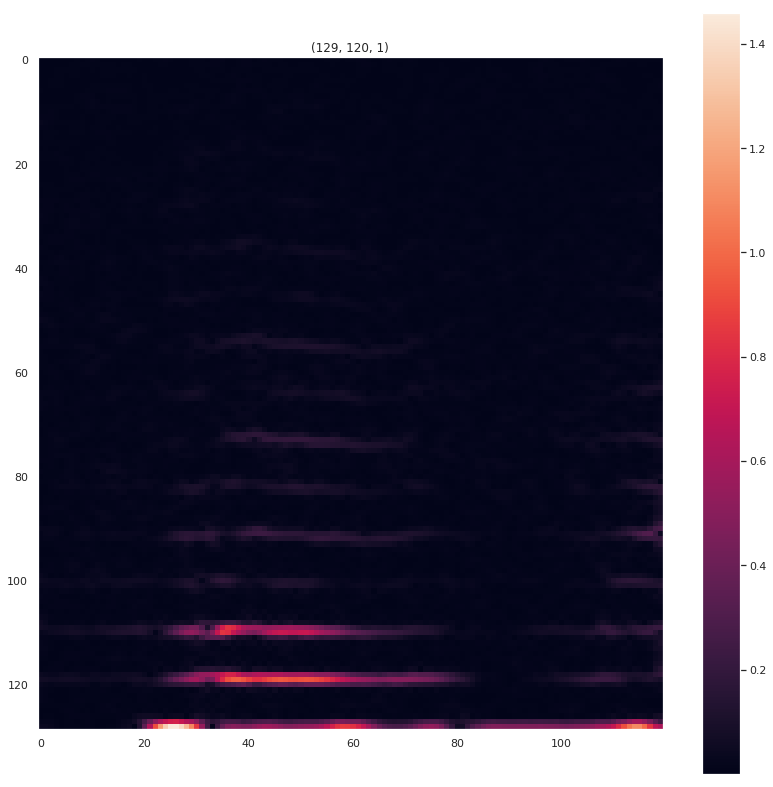

In [18]:
plt.figure(figsize=(14,14))
plt.imshow(x_batch[0].squeeze())
plt.colorbar()
plt.grid(False)
plt.title(str(x_batch[0].shape))

In [19]:
new_model.fit_generator(train_generator(),
    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
    validation_data = valid_generator(),
    validation_steps = int(math.ceil(float(len(X_test)) / float(batch_size))),
    epochs = epochs,
    callbacks = callbacks_list,
    shuffle = False)

Epoch 1/100
318/319 [============================>.] - ETA: 0s - loss: 0.4999 - acc: 0.7600
Epoch 00001: val_acc improved from -inf to 0.58314, saving model to ./data/wingbeats_DenseNet121_binary.h5
319/319 [==============================] - 72s 226ms/step - loss: 0.4997 - acc: 0.7601 - val_loss: 0.6128 - val_acc: 0.5831
Epoch 2/100
318/319 [============================>.] - ETA: 0s - loss: 0.3931 - acc: 0.8279
Epoch 00002: val_acc improved from 0.58314 to 0.62549, saving model to ./data/wingbeats_DenseNet121_binary.h5
319/319 [==============================] - 69s 216ms/step - loss: 0.3932 - acc: 0.8277 - val_loss: 0.5796 - val_acc: 0.6255
Epoch 3/100
318/319 [============================>.] - ETA: 0s - loss: 0.3528 - acc: 0.8474
Epoch 00003: val_acc did not improve
319/319 [==============================] - 69s 217ms/step - loss: 0.3529 - acc: 0.8471 - val_loss: 0.6543 - val_acc: 0.6133
Epoch 4/100
318/319 [============================>.] - ETA: 0s - loss: 0.3277 - acc: 0.8601
Epoch 

In [20]:
# new_model.summary()